In [1]:
import numpy as np
from PIL import Image, ImageColor
from google.colab import drive

In [2]:
drive.mount('/content/drive')
drive_path = 'drive/My Drive/'

Mounted at /content/drive


In [3]:
parts = {10: {'col': 'orange', 'name':'hood'},
         20: {'col':'darkgreen', 'name':'front door'},
         30: {'col':'yellow', 'name':'rear door'},
         40: {'col':'cyan', 'name':'frame'},
         50: {'col':'purple', 'name':'rear quarter panel'},
         60: {'col':'lightgreen', 'name':'trunk lid'},
         70: {'col':'blue', 'name':'fender'},
         80: {'col':'pink', 'name':'bumper'},
         90: {'col':'darkgray', 'name':'rest of car'},
         0 : {'col':'black', 'name':'background'}}

def display_car(data_arr):
    # Can take both full data and already split data
    if data_arr.shape[2] > 3: data_arr = data_arr[:,:,:3]
    img = Image.fromarray(data_arr)
    display(img) # img.show() for jupyter

def display_labels(data_arr):
    # Can take both full data and already split data
    if data_arr.ndim > 2: data_arr = data_arr[:,:,3]
    img = Image.fromarray(data_arr)
    pixels = list(img.getdata())
    pixels = [ImageColor.getrgb(parts.get(pixel)['col']) for pixel in pixels]
    image = Image.new("RGB", (256, 256), (0,0,0))
    image.putdata(pixels)
    display(image)


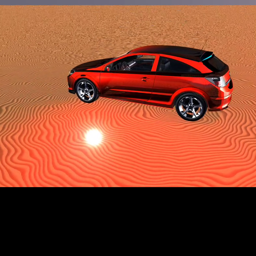

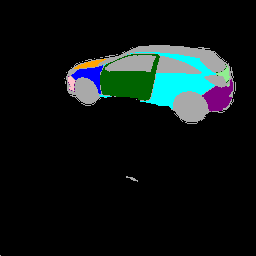

In [4]:
#arr = np.load('./carseg_data/arrays/orange_3_doors_0101.npy') # Local
arr = np.load(f'{drive_path}/carseg_data/arrays/orange_3_doors_0101.npy') # Drive

display_car(arr)
display_labels(arr)

In [5]:
import os
import numpy as np
from torch.utils.data import Dataset

class CarDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.filenames = os.listdir(self.root)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        filename = self.filenames[index]
        arr = np.load(os.path.join(self.root, filename))
        car = arr[:,:,0:3]
        labels = arr[:,:,3]

        data_dict = {'car': car, 'labels': labels}

        return data_dict

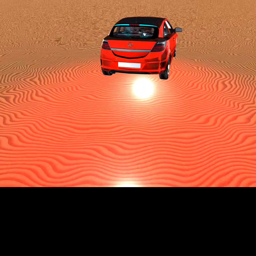

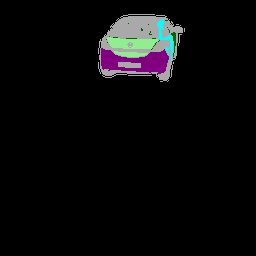

In [6]:
#ds = CarDataset('./carseg_data/arrays') # Local
ds = CarDataset(f'{drive_path}/carseg_data/arrays') # Drive
# 1502 as example
data = ds[1000]
car = data['car']
labels = data['labels']
display_car(car)
display_labels(labels)

In [7]:
from torch.utils.data import DataLoader, Subset, random_split


ds = CarDataset(f'{drive_path}/carseg_data/arrays')  # Drive

total_samples = len(ds)

# Specify the ratio for train, val, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the number of samples for each set
train_size = int(train_ratio * total_samples)
val_size = int(val_ratio * total_samples)
test_size = total_samples - train_size - val_size

# Use random_split to create random subsets
train_dataset, val_dataset, test_dataset = random_split(ds, [train_size, val_size, test_size])

# Create DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



In [8]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

In [10]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        self.encoder0 = nn.Sequential(ConvBlock(in_channels, 64))
        self.encoder1 = nn.Sequential(nn.MaxPool2d(2,2), ConvBlock(64, 128))
        self.encoder2 = nn.Sequential(nn.MaxPool2d(2,2), ConvBlock(128, 256))
        self.bottleneck = nn.Sequential(nn.MaxPool2d(2,2), ConvBlock(256,512), nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2))
        self.decoder0 = nn.Sequential(ConvBlock(512,256), nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2))
        self.decoder1 = nn.Sequential(ConvBlock(256,128), nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2))
        self.decoder2 = nn.Sequential(ConvBlock(128,64), nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1))

    def forward(self, x):
        x0 = self.encoder0(x)
        x1 = self.encoder1(x0)
        x2 = self.encoder2(x1)
        x3 = self.bottleneck(x2)
        x3 = self.decoder0(torch.cat([x2,x3],dim=1))
        x3 = self.decoder1(torch.cat([x1,x3],dim=1))
        x3 = self.decoder2(torch.cat([x0,x3],dim=1))

        return x3

In [11]:
model = UNet(3, 10)
inputs = torch.randn(1, 3, 256, 256)
output = model(inputs)
print(output.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.Size([1, 10, 256, 256])


UNet(
  (encoder0): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
  )
  (encoder1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [13]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0

    for batch in train_loader:
        inputs, labels = batch['car'].to(device), batch['labels'].to(device)
        inputs = torch.permute(inputs, (0, 3, 1, 2))
        inputs = inputs.float()
        labels = labels / 10
        labels = labels.long().to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        if torch.isnan(loss):
            print("Loss is NaN. Check your model and data.")
            break

        total_train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train_predictions += (predicted == labels).sum().item()
        total_train_predictions += labels.numel()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0

    for batch in val_loader:
        inputs, labels = batch['car'].to(device), batch['labels'].to(device)
        inputs = torch.permute(inputs, (0, 3, 1, 2))
        inputs = inputs.float()
        labels = labels / 10
        labels = labels.long().to(device)

        with torch.no_grad():
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val_predictions += (predicted == labels).sum().item()
            total_val_predictions += labels.numel()

    # Print training and validation information
    train_accuracy = correct_train_predictions / total_train_predictions
    val_accuracy = correct_val_predictions / total_val_predictions

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {(total_train_loss / len(train_loader)):.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {(total_val_loss / len(val_loader)):.4f}, Val Accuracy: {val_accuracy:.4f}")

# Test the model on the test dataset
model.eval()
total_test_predictions = 0
correct_test_predictions = 0

for batch in test_loader:
    inputs, labels = batch['car'].to(device), batch['labels'].to(device)
    inputs = torch.permute(inputs, (0, 3, 1, 2))
    inputs = inputs.float()
    labels = labels / 10
    labels = labels.long().to(device)

    with torch.no_grad():
        outputs = model(inputs)

        # Calculate accuracy on the test set
        _, predicted = torch.max(outputs, 1)
        correct_test_predictions += (predicted == labels).sum().item()
        total_test_predictions += labels.numel()

# Calculate and print test accuracy
test_accuracy = correct_test_predictions / total_test_predictions
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/100, Train Loss: 0.6503, Train Accuracy: 0.8354, Val Loss: 0.4896, Val Accuracy: 0.8290
Epoch 2/100, Train Loss: 0.3849, Train Accuracy: 0.8680, Val Loss: 0.5430, Val Accuracy: 0.8371
Epoch 3/100, Train Loss: 0.3229, Train Accuracy: 0.8845, Val Loss: 0.4504, Val Accuracy: 0.8546
Epoch 4/100, Train Loss: 0.2856, Train Accuracy: 0.8945, Val Loss: 0.4264, Val Accuracy: 0.8601
Epoch 5/100, Train Loss: 0.2611, Train Accuracy: 0.9040, Val Loss: 1.5671, Val Accuracy: 0.6012
Epoch 6/100, Train Loss: 0.2449, Train Accuracy: 0.9096, Val Loss: 0.2930, Val Accuracy: 0.8856
Epoch 7/100, Train Loss: 0.2199, Train Accuracy: 0.9175, Val Loss: 0.2651, Val Accuracy: 0.9068
Epoch 8/100, Train Loss: 0.1997, Train Accuracy: 0.9242, Val Loss: 0.2312, Val Accuracy: 0.9138
Epoch 9/100, Train Loss: 0.1833, Train Accuracy: 0.9304, Val Loss: 0.3526, Val Accuracy: 0.8557
Epoch 10/100, Train Loss: 0.1836, Train Accuracy: 0.9314, Val Loss: 0.3539, Val Accuracy: 0.8796
Epoch 11/100, Train Loss: 0.1738, Train

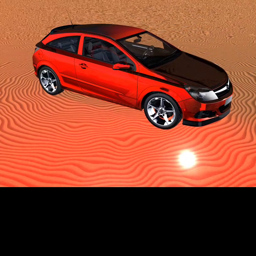

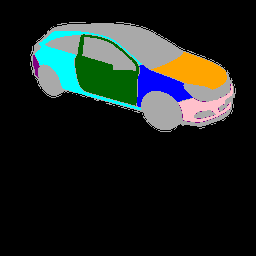

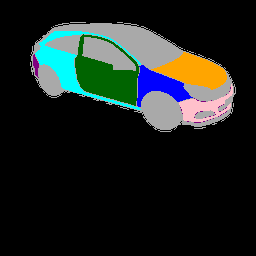

In [16]:
import random
rand = random.randint(0, len(ds))
data = ds[rand]
car = data['car']
labels = data['labels']

input = torch.from_numpy(car)
input = input.to(device)
input = input.unsqueeze(0)
input = torch.permute(input, (0, 3, 1, 2))
outputs = model(input.float())

_, predicted = torch.max(outputs, 1)
predicted = predicted.squeeze()
predicted = predicted.cpu().detach().numpy()
predicted = predicted*10
predicted = predicted.astype(np.uint8)


display_car(car)
display_labels(labels)
display_labels(predicted)



In [17]:
model_path = 'model1.pth'
torch.save(model, model_path)
